## Basic Setting

### Library Install

In [ ]:
!pip install swig
!pip install gymnasium[box2d]

### Library Import

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import imageio
from collections import defaultdict, deque, namedtuple
from time import time

### DQN Module

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

### Utils

In [ ]:
def save_model_parameters(model):
    params_dict = {name: param.detach().cpu().numpy().copy() for name, param in model.named_parameters()}
    return params_dict

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(self.transition(state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        return self.transition(*zip(*transitions))

    def __len__(self):
        return len(self.buffer)

def select_tabular_action(state, Q, epsilon, action_size):
    if random.random() < epsilon:
        return random.randint(0, action_size - 1)
    else:
        return np.argmax(Q[state])

def select_dqn_action(state, policy_net, epsilon, action_size):
    if random.random() < epsilon:
        return random.randint(0, action_size - 1)
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        return policy_net(state_tensor).argmax().item()


In [ ]:
def plot_results(results, ylim = None):
    sns.set(style="darkgrid")
    df = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="Episode", y="Reward", hue="Algorithm")
    plt.title("Performance of RL Algorithms")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    if ylim is not None :
        plt.ylim(ylim)
    plt.show()

In [ ]:
def train_tabular(algorithm, env_name):
    env = gym.make(env_name)
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = EPSILON_START
    rewards = []
    total_episode_time = 0

    for episode in range(EPISODES):
        state, _ = env.reset()
        state = tuple(state)
        done = False
        total_reward = 0
        action = random.choice(range(nA))

        while not done:
            epsilon = max(EPSILON_END, epsilon - (EPSILON_START - EPSILON_END) / EPSILON_DECAY)
            s = time()
            next_state, reward, done, _, _ = env.step(action)
            e = time()
            total_episode_time += e - s
            next_state = tuple(next_state)
            total_reward += reward

            if algorithm == "SARSA":
                next_action = select_tabular_action(next_state, Q, epsilon, nA)
                Q[state][action] += ALPHA * (reward + GAMMA * Q[next_state][next_action] - Q[state][action])
                state, action = next_state, next_action
            else:  # Q-Learning
                Q[state][action] += ALPHA * (reward + GAMMA * np.max(Q[next_state]) - Q[state][action])
                state = next_state
                action = select_tabular_action(state, Q, epsilon, nA)

        rewards.append(total_reward)
        if episode % 50 == 0 :
            print(f"{algorithm} - Episode {episode+1}, Reward: {total_reward:.2f}")
    env.close()
    # print(f"Total Episode Time : {total_episode_time:.5f}")
    return rewards, Q

def train_dqn(env_name):
    env = gym.make(env_name)

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    policy_net = DQN(state_size, action_size).to(device)
    target_net = DQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
    replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)
    epsilon = EPSILON_START
    steps_done = 0
    rewards = []
    total_episode_time = 0

    dqn_dict = {}

    for episode in range(EPISODES):
        state, _ = env.reset()
        total_reward = 0
        done = False

        frames = []

        while not done:
            epsilon = max(EPSILON_END, epsilon - (EPSILON_START - EPSILON_END) / EPSILON_DECAY)

            frames.append(env.render())

            action = select_dqn_action(state, policy_net, epsilon, action_size)
            s = time()
            next_state, reward, done, _, _ = env.step(action)
            e = time()
            total_episode_time += e - s

            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Training
            if len(replay_buffer) > BATCH_SIZE:
                batch = replay_buffer.sample(BATCH_SIZE)

                states = torch.tensor(batch.state, dtype=torch.float32).to(device)
                actions = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1).to(device)
                rewards_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
                next_states = torch.tensor(batch.next_state, dtype=torch.float32).to(device)
                dones = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

                # Q-learning update
                current_q = policy_net(states).gather(1, actions)
                max_next_q = target_net(next_states).max(1)[0].detach().unsqueeze(1)
                target_q = rewards_batch + GAMMA * max_next_q * (1 - dones)

                loss = nn.functional.mse_loss(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            steps_done += 1
            if steps_done % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

        rewards.append(total_reward)
        # if total_reward < -1000 :
        #     print(f"Total Reward : {total_reward} | {policy_net.fc1.weight[:5, 0]}")
        #     dqn_dict[f'{total_reward}'] = save_model_parameters(policy_net)
        #     # imageio.mimsave(f"dqn_lander_{total_reward}.gif", frames, fps=30)

        # if episode % 100 == 0 :
        #     print(f"Total Reward : {total_reward} | {policy_net.fc1.weight[:5, 0]}")
        #     dqn_dict[f'{episode}'] = save_model_parameters(policy_net)
        #     # imageio.mimsave(f"dqn_lander_{total_reward}_{episode}.gif", frames, fps=30)


        if episode % 40 == 0 :
            print(f"DQN - Episode {episode+1}, Reward: {total_reward:.2f}")
    # print(f"Total Episode Time : {total_episode_time:.5f}")
    env.close()
    return rewards, policy_net, dqn_dict

### HyperParams

In [ ]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Hyperparameters
EPISODES = 1500
ALPHA = 0.1
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.02
EPSILON_DECAY = 50000
BATCH_SIZE = 64
TARGET_UPDATE = 1000
LEARNING_RATE = 1e-3
REPLAY_BUFFER_SIZE = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env_name = "LunarLander-v3"

## Training Models

### SARSA

In [ ]:
# SARSA
sarsa_start = time()
sarsa_rewards, sarsa_Q = train_tabular("SARSA", env_name)
sarsa_end = time()

sarsa_results = []
for i, r in enumerate(sarsa_rewards):
    sarsa_results.append({"Episode": i+1, "Reward": r, "Algorithm": "SARSA"})

print(f"Total Sarsa Training Time : {sarsa_end - sarsa_start:.4f} | Per Episdoe : {(sarsa_end - sarsa_start)/500:.4f}")

SARSA - Episode 1, Reward: -111.65
SARSA - Episode 51, Reward: -119.08
SARSA - Episode 101, Reward: -153.96
SARSA - Episode 151, Reward: 0.03
SARSA - Episode 201, Reward: -107.48
SARSA - Episode 251, Reward: -88.18
SARSA - Episode 301, Reward: -91.23
SARSA - Episode 351, Reward: -118.02
SARSA - Episode 401, Reward: -108.69
SARSA - Episode 451, Reward: -133.05
SARSA - Episode 501, Reward: -100.60
SARSA - Episode 551, Reward: -143.13
SARSA - Episode 601, Reward: -154.35
SARSA - Episode 651, Reward: -134.63
SARSA - Episode 701, Reward: -108.96
SARSA - Episode 751, Reward: -134.45
SARSA - Episode 801, Reward: -55.70
SARSA - Episode 851, Reward: -117.59
SARSA - Episode 901, Reward: -167.82
SARSA - Episode 951, Reward: -142.01
SARSA - Episode 1001, Reward: -118.46
SARSA - Episode 1051, Reward: -109.93
SARSA - Episode 1101, Reward: -141.33
SARSA - Episode 1151, Reward: -113.07
SARSA - Episode 1201, Reward: -123.09
SARSA - Episode 1251, Reward: -48.51
SARSA - Episode 1301, Reward: -174.88
SARS

### Q-Learning

In [ ]:
# Q-Learning
q_learning_start = time()
q_learning_rewards, q_learning_Q = train_tabular("Q-Learning", env_name)
q_learning_end = time()

q_learning_results = []
for i, r in enumerate(q_learning_rewards):
    q_learning_results.append({"Episode": i+1, "Reward": r, "Algorithm": "Q-Learning"})

print(f"Total Q-learning Training Time : {q_learning_end - q_learning_start:.4f} | Per Episdoe : {(q_learning_end - q_learning_start)/500:.4f}")

Q-Learning - Episode 1, Reward: -327.96
Q-Learning - Episode 51, Reward: -238.10
Q-Learning - Episode 101, Reward: -107.23
Q-Learning - Episode 151, Reward: -108.79
Q-Learning - Episode 201, Reward: -100.98
Q-Learning - Episode 251, Reward: -137.24
Q-Learning - Episode 301, Reward: -129.49
Q-Learning - Episode 351, Reward: -119.38
Q-Learning - Episode 401, Reward: -113.69
Q-Learning - Episode 451, Reward: -119.57
Q-Learning - Episode 501, Reward: 13.70
Q-Learning - Episode 551, Reward: -140.00
Q-Learning - Episode 601, Reward: -195.49
Q-Learning - Episode 651, Reward: -26.26
Q-Learning - Episode 701, Reward: -169.05
Q-Learning - Episode 751, Reward: -170.48
Q-Learning - Episode 801, Reward: -94.18
Q-Learning - Episode 851, Reward: -177.34
Q-Learning - Episode 901, Reward: 6.27
Q-Learning - Episode 951, Reward: -109.95
Q-Learning - Episode 1001, Reward: -170.40
Q-Learning - Episode 1051, Reward: -164.00
Q-Learning - Episode 1101, Reward: -177.63
Q-Learning - Episode 1151, Reward: -119.1

### DQN Training

In [ ]:
# DQN Training
dqn_start = time()
dqn_rewards, dqn_model, dqn_dict = train_dqn(env_name)
dqn_end = time()

dqn_results = []
for i, r in enumerate(dqn_rewards):
    dqn_results.append({"Episode": i+1, "Reward": r, "Algorithm": "DQN"})

print(f"Total DQN Training Time : {dqn_end - dqn_start:.4f} | Per Episdoe : {(dqn_end - dqn_start)/500:.4f}")


Total Reward : -158.4219098336222 | tensor([ 0.3128,  0.3180,  0.2725, -0.2778,  0.2628],
       grad_fn=<SelectBackward0>)
DQN - Episode 1, Reward: -158.42
DQN - Episode 41, Reward: -152.21
DQN - Episode 81, Reward: -95.59
Total Reward : -103.74926359050642 | tensor([ 0.3313,  0.3462,  0.8026, -0.8183,  0.6850],
       grad_fn=<SelectBackward0>)
DQN - Episode 121, Reward: 6.63
DQN - Episode 161, Reward: -76.65
Total Reward : -92.05246270801102 | tensor([ 0.2787,  0.4147,  0.6540, -1.3305,  1.0431],
       grad_fn=<SelectBackward0>)
DQN - Episode 201, Reward: -92.05
Total Reward : -3174.9247530939533 | tensor([ 0.0285, -0.2960,  0.7592, -1.6575,  1.4236],
       grad_fn=<SelectBackward0>)
DQN - Episode 241, Reward: -167.60
DQN - Episode 281, Reward: 214.43
Total Reward : 129.90674932864633 | tensor([-0.3366, -0.2986,  0.7346, -1.6273,  1.5306],
       grad_fn=<SelectBackward0>)
DQN - Episode 321, Reward: 219.28
DQN - Episode 361, Reward: 277.91
Total Reward : 152.94245722160952 | tenso

## Results

### Main Rewards

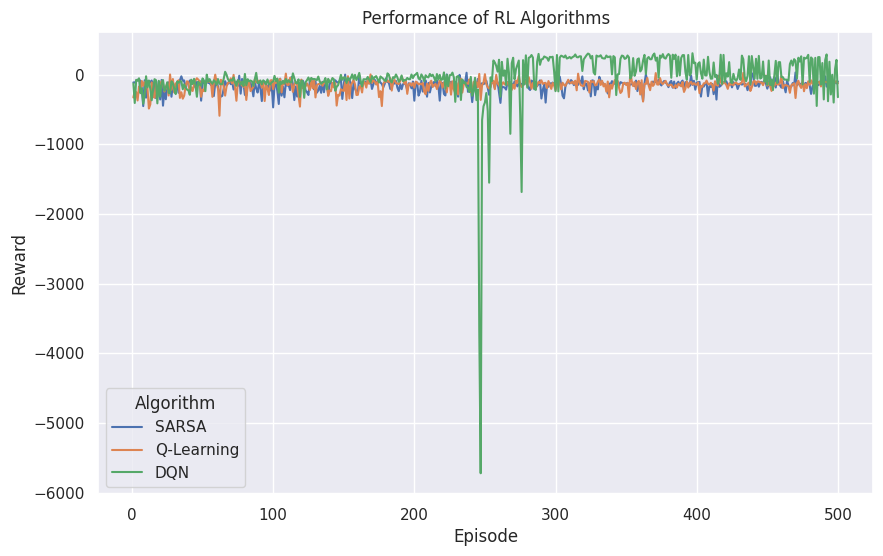

In [ ]:
total_result = sarsa_results[:500] + q_learning_results[:500] + dqn_results
plot_results(total_result)

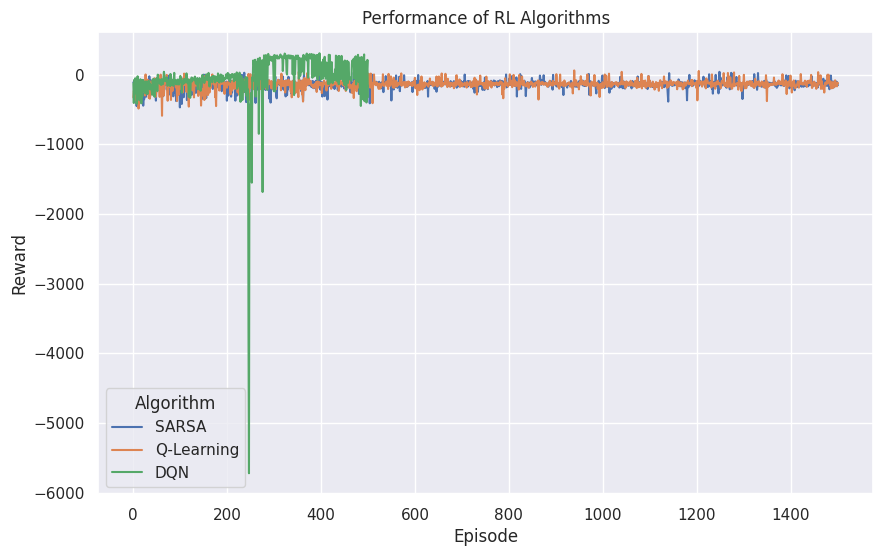

In [ ]:
total_result = sarsa_results + q_learning_results + dqn_results
plot_results(total_result)

### Make GIF of Each Model

In [ ]:
def save_dqn_gif(env_name, model, output_path, seed = 10):
    """Save a GIF of the agent's behavior in the environment."""
    env = gym.make(env_name, render_mode="rgb_array")
    frames = []
    state, _ = env.reset(seed = seed)
    done = False
    total_reward = 0
    while not done:
        frames.append(env.render())
        action = select_dqn_action(state, model, 0, env.action_space.n)
        state, reward, done, _, _ = env.step(action)
        total_reward += reward

    print(f"Total Reward : {total_reward}")
    env.close()
    imageio.mimsave(output_path, frames, fps=30)
    print(f"GIF saved at {output_path}")

In [ ]:
def save_tabular_gif(env_name, Q, output_path, seed = 10):
    """Save a GIF using the Q-table (SARSA or Q-Learning)."""
    env = gym.make(env_name, render_mode="rgb_array")
    frames = []
    state, _ = env.reset(seed = seed)
    state = tuple(state)
    done = False

    while not done:
        frames.append(env.render())

        action = np.argmax(Q[state])
        next_state, _, done, _, _ = env.step(action)
        state = tuple(next_state)

    env.close()

    imageio.mimsave(output_path, frames, fps=30)
    print(f"GIF saved at {output_path}")


In [ ]:
# Save GIFs
save_tabular_gif(env_name, sarsa_Q, "sarsa_lander.gif", seed = 2)
save_tabular_gif(env_name, q_learning_Q, "q_learning_lander.gif", seed = 2)
save_dqn_gif(env_name, dqn_model, "dqn_lander.gif", seed = 2)

GIF saved at sarsa_lander.gif
GIF saved at q_learning_lander.gif
GIF saved at dqn_lander.gif


### Make GIF in One Frame

In [ ]:
seed = 18

rewards = [0, 0, 0]
env = gym.make(env_name, render_mode="rgb_array")
dqn_frames = []
state, _ = env.reset(seed = seed)
done = False

while not done:
    dqn_frames.append(env.render())
    action = select_dqn_action(state, dqn_model, 0, env.action_space.n)
    state, reward, done, _, _ = env.step(action)
    rewards[0] += reward

env.close()

sarsa_frames = []
state, _ = env.reset(seed = seed)
state = tuple(state)
done = False

while not done:
    sarsa_frames.append(env.render())

    action = np.argmax(sarsa_Q[state])
    next_state, reward, done, _, _ = env.step(action)
    state = tuple(next_state)
    rewards[1] += reward

env.close()

q_learning_frames = []
state, _ = env.reset(seed = seed)
state = tuple(state)
done = False

while not done:
    q_learning_frames.append(env.render())

    action = np.argmax(q_learning_Q[state])
    next_state, reward, done, _, _ = env.step(action)
    state = tuple(next_state)
    rewards[2] += reward

env.close()

283.63850843665045 -197.49185852866935 -197.49185852866935


In [ ]:
import cv2

agent_colors = [
    (102, 102, 255),   # Red for DQN
    (178, 255, 102),   # Green for SARSA
    (255, 178, 102)    # Blue for Q-Learning
]
lander_color_range = ([90, 100, 90], [140, 120, 255])

def replace_lander_color(frame, new_color):
    """Replace the Lander's purple color with the specified new_color."""
    mask = cv2.inRange(frame, np.array(lander_color_range[0]), np.array(lander_color_range[1]))
    frame_colored = frame.copy()
    frame_colored[mask > 0] = new_color
    return frame_colored


In [ ]:
for i in range(dqn_frames.__len__()) :
    if i < sarsa_frames.__len__() :
        dqn_frame = dqn_frames[i]
        sarsa_frame = sarsa_frames[i]
        q_learning_frame = q_learning_frames[i]
    else :
        dqn_frame = dqn_frames[i]
        sarsa_frame = sarsa_frames[-1]
        q_learning_frame = q_learning_frames[-1]

    dqn_frame_color = replace_lander_color(dqn_frame, agent_colors[0])
    sarsa_frame_color = replace_lander_color(sarsa_frame, agent_colors[1])
    q_learning_frame_color = replace_lander_color(q_learning_frame, agent_colors[2])

    dqn_frames[i] = dqn_frame_color
    if i < len(sarsa_frames) :
        sarsa_frames[i] = sarsa_frame_color
        q_learning_frames[i] = q_learning_frame_color
    else :
        sarsa_frames.append(sarsa_frame_color)
        q_learning_frames.append(q_learning_frame_color)

In [ ]:
combined_frames = []
for i in range(dqn_frames.__len__()) :
    total_frame = np.maximum(dqn_frames[i], sarsa_frames[i])
    total_frame = np.maximum(total_frame, q_learning_frames[i])
    combined_frames.append(total_frame)

In [ ]:
imageio.mimsave("Combined_lander.gif", combined_frames, fps=30)

### Time Complexity

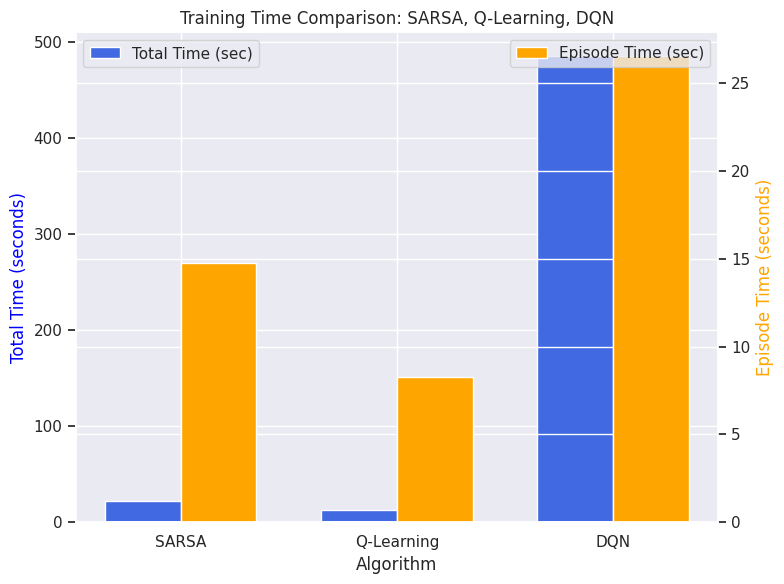

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

algorithms = ['SARSA', 'Q-Learning', 'DQN']
total_time = [21.72, 12.28, 485.79]
episode_time = [14.78, 8.28, 26.55]

bar_width = 0.35
index = np.arange(len(algorithms))

fig, ax1 = plt.subplots(figsize=(8, 6))

bars1 = ax1.bar(index, total_time, bar_width, label='Total Time (sec)', color='royalblue')

ax2 = ax1.twinx()

bars2 = ax2.bar(index + bar_width, episode_time, bar_width, label='Episode Time (sec)', color='orange')

ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Total Time (seconds)', color='blue')
ax2.set_ylabel('Episode Time (seconds)', color='orange')

ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(algorithms)

plt.title('Training Time Comparison: SARSA, Q-Learning, DQN')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### GIF of DQN in Training

In [ ]:
def load_model_parameters(model, params_dict):
    state_dict = {name: torch.tensor(param) for name, param in params_dict.items()}
    model.load_state_dict(state_dict)
    return model

In [ ]:
for a in dqn_dict.keys() :
    env = gym.make(env_name, render_mode="rgb_array")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    temp_dqn_model = DQN(state_size, action_size).to(device)

    load_model_parameters(temp_dqn_model, dqn_dict[a])

    save_dqn_gif(env_name, temp_dqn_model, f"dqn_lander_{a}.gif", seed = 2)

Total Reward : -622.1362006217593
GIF saved at dqn_lander_0.gif
Total Reward : -82.52864239663697
GIF saved at dqn_lander_100.gif
Total Reward : -91.61246741825141
GIF saved at dqn_lander_200.gif
Total Reward : -307.8914491478082
GIF saved at dqn_lander_-3174.9247530939533.gif
Total Reward : -149.7756475596197
GIF saved at dqn_lander_300.gif
Total Reward : 212.85007737133333
GIF saved at dqn_lander_400.gif
